In [3]:
from sklearn import tree  
from sklearn.externals import joblib
import pydotplus
from sklearn.datasets import load_iris
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import itertools
#import graphviz 
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=16)
    plt.yticks(tick_marks, classes,fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)
    return cm

def get_dataset(file_name,data_class_name_num,data_class_name):
    data = pd.read_csv(file_name)
    data = data.reset_index(drop=True)
    data = data.dropna()
    X = data.iloc[:,0:4]
    X = X.reset_index(drop=True)
    X = X.dropna()
    Y = data.iloc[:,-1]
    Y = Y.replace(data_class_name_num, data_class_name)
    Y = Y.reset_index(drop=True)
    Y = Y.dropna()

    min_max_scaler = preprocessing.MinMaxScaler()
    values = X.values
    values_scaled = min_max_scaler.fit_transform(values)
#     X = pd.DataFrame(values_scaled)
#     print(df.head())
    return X,Y

def calc_stat(clf,X,Y):
    score = clf.score(X,Y)
    y_true = Y;
    y_pred = clf.predict(X) 
    precision,recall,fbeta_score,support = precision_recall_fscore_support(y_true, 
                                                                       y_pred, 
                                                                       beta=1.0, 
                                                                       labels=None, 
                                                                       pos_label=1, 
                                                                       average=None, 
                                                                       warn_for=('precision', 'recall', 'f-score'), 
                                                                       sample_weight=None)
    return score,precision,recall,fbeta_score,support 


In [4]:
own_data = True
experiment = 1
no_off_class = 5
data_feature_names = [ 'altitude', 'vel_x', 'vel_y', 'vel_z' ]
data_class_name_num = [1, 2, 3, 4, 5]
data_class_name = ['Hold', 'Takeoff', 'Hover', 'Search', 'Land']

data_feature_names_gtri = [ 'roll', 'pitch', 'yaw', 'rollspeed','pitchspeed','yawspeed', 'xacc', 'yacc', 'zacc']
data_class_name_num_gtri = [0, 1, 2, 3]
data_class_name_gtri = ['Hold', 'Fly Orbit and Observe', 'Fly Search Pattern', 'Survey Target']


datagtri = pd.read_csv('GTRIdataset.csv')
datagtri = datagtri.dropna()
gtriX = datagtri.iloc[:,1:10]
gtriX = gtriX.reset_index(drop=True)
gtriX = gtriX.dropna()
gtriY = datagtri.iloc[:,10]
gtriY = gtriY.replace(data_class_name_num_gtri, data_class_name_gtri)
gtriY = gtriY.reset_index(drop=True)
gtriY = gtriY.dropna()


intelX,intelY = get_dataset('intelDroneData.csv',data_class_name_num,data_class_name)

print('Real Data intel: ', 'Hold: ', len(intelY[intelY=='Hold']),
      ' Takeoff: ', len(intelY[intelY=='Takeoff']),
      ' Hover: ', len(intelY[intelY=='Hover']),
      ' Search: ', len(intelY[intelY=='Search']),
      ' Land: ', len(intelY[intelY=='Land']),
      ' Total: ', len(intelY))

arX,arY = get_dataset('arDroneData.csv',data_class_name_num,data_class_name)

print('Real Data ar: ', 'Hold: ', len(arY[arY=='Hold']),
      ' Takeoff: ', len(arY[arY=='Takeoff']),
      ' Hover: ', len(arY[arY=='Hover']),
      ' Search: ', len(arY[arY=='Search']),
      ' Land: ', len(arY[arY=='Land']))

inarX,inarY = get_dataset('intelardata.csv',data_class_name_num,data_class_name)
inarsimX,inarsimY = get_dataset('intelarsimdata.csv',data_class_name_num,data_class_name)

simirisX,simirisY = get_dataset('datasetiris.csv',data_class_name_num,data_class_name)
simsoloX,simsoloY = get_dataset('datasetsolo.csv',data_class_name_num,data_class_name)
simX,simY = get_dataset('gazeboSimulationData.csv',data_class_name_num,data_class_name)

simconcatX = pd.concat([simirisX,simsoloX,intelX],axis=0)
simconcatY = pd.concat([simirisY,simsoloY,intelY],axis=0)

simonlyconcatX = pd.concat([simirisX,simsoloX],axis=0)
simonlyconcatY = pd.concat([simirisY,simsoloY],axis=0)

allX = pd.concat([simirisX,simsoloX,intelX,arX],axis=0)
allY = pd.concat([simirisY,simsoloY,intelY,arY],axis=0)

# simX,simY = simsoloX,simsoloY
# simX,simY = simirisX,simirisY
# simX,simY = simconcatX,simconcatY
print('Simulation Data: ', 'Hold: ', len(simY[simY=='Hold']),
      ' Takeoff: ', len(simY[simY=='Takeoff']),
      ' Hover: ', len(simY[simY=='Hover']),
      ' Search: ', len(simY[simY=='Search']),
      ' Land: ', len(simY[simY=='Land']),
      ' Total: ', len(simY))

print('Simulation iris Data: ', 'Hold: ', len(simirisY[simirisY=='Hold']),
      ' Takeoff: ', len(simirisY[simirisY=='Takeoff']),
      ' Hover: ', len(simirisY[simirisY=='Hover']),
      ' Search: ', len(simirisY[simirisY=='Search']),
      ' Land: ', len(simirisY[simirisY=='Land']),
      ' Total: ', len(simirisY))

print('Simulation solo Data: ', 'Hold: ', len(simsoloY[simsoloY=='Hold']),
      ' Takeoff: ', len(simsoloY[simsoloY=='Takeoff']),
      ' Hover: ', len(simsoloY[simsoloY=='Hover']),
      ' Search: ', len(simsoloY[simsoloY=='Search']),
      ' Land: ', len(simsoloY[simsoloY=='Land']),
      ' Total: ', len(simsoloY))

print('Simulation concat Data: ', 'Hold: ', len(simconcatY[simconcatY=='Hold']),
      ' Takeoff: ', len(simconcatY[simconcatY=='Takeoff']),
      ' Hover: ', len(simconcatY[simconcatY=='Hover']),
      ' Search: ', len(simconcatY[simconcatY=='Search']),
      ' Land: ', len(simconcatY[simconcatY=='Land']),
      ' Total: ', len(simconcatY))

Real Data intel:  Hold:  9862  Takeoff:  501  Hover:  1767  Search:  1251  Land:  598  Total:  13979
Real Data ar:  Hold:  4633  Takeoff:  4308  Hover:  21453  Search:  14447  Land:  2050
Simulation Data:  Hold:  3715  Takeoff:  795  Hover:  1185  Search:  8482  Land:  837  Total:  15014
Simulation iris Data:  Hold:  6323  Takeoff:  684  Hover:  6285  Search:  5597  Land:  995  Total:  19884
Simulation solo Data:  Hold:  11817  Takeoff:  1014  Hover:  4586  Search:  7122  Land:  1472  Total:  26011
Simulation concat Data:  Hold:  28002  Takeoff:  2199  Hover:  12638  Search:  13970  Land:  3065  Total:  59874


/Users/mrinmoysarkar/Downloads/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


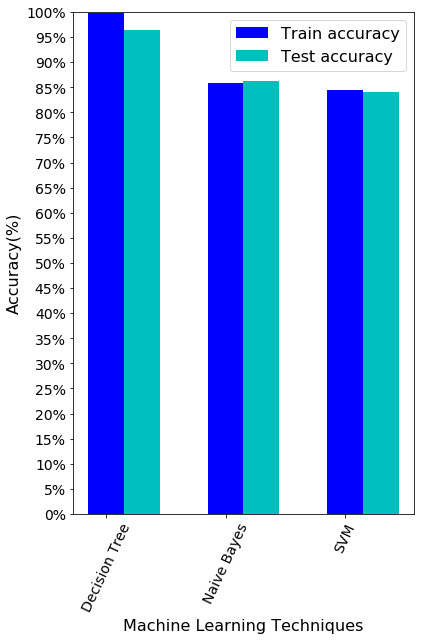

Simulation testy Data:  Hold:  381  Takeoff:  82  Hover:  128  Search:  831  Land:  80  Total:  1502
Confusion matrix, without normalization
[[377   0   0   0   4]
 [  0   0   0 128   0]
 [ 31   0  38   4   7]
 [  0   0   0 831   0]
 [ 34   0   0  42   6]]
Normalized confusion matrix
[[0.99 0.   0.   0.   0.01]
 [0.   0.   0.   1.   0.  ]
 [0.39 0.   0.47 0.05 0.09]
 [0.   0.   0.   1.   0.  ]
 [0.41 0.   0.   0.51 0.07]]


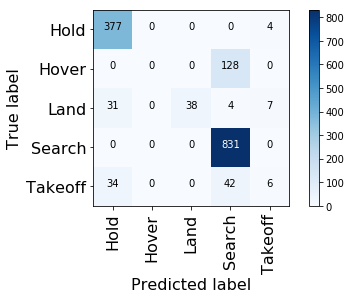

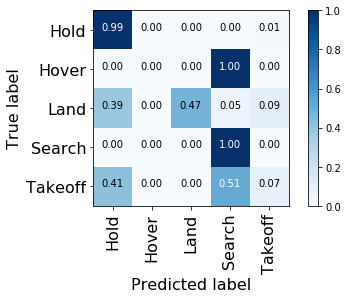

In [38]:
# # to test gtri data
# own_data = False
# dataX = gtriX
# dataY = gtriY
# data_feature_names = data_feature_names_gtri
# data_class_name = data_class_name_gtri

# # to test intel drone data
# dataX = intelX
# dataY = intelY

# # to test ar drone data
# dataX = arX
# dataY = arY

# #to test simulation data
dataX = simX
dataY = simY

# dataX = simirisX
# dataY = simirisY

# dataX = simsoloX
# dataY = simsoloY

#dataX = simconcatX
#dataY = simconcatY

# dataX=inarX
# dataY=inarY

# dataX=inarsimX
# dataY=inarsimY

# dataX = allX
# dataY = allY

Noofrun = 3


trainPrecision = np.zeros(no_off_class)
trainRecall = np.zeros(no_off_class)
trainF1score = np.zeros(no_off_class)


testPrecision = np.zeros(no_off_class)
testRecall = np.zeros(no_off_class)
testF1score = np.zeros(no_off_class)


intelPrecision = np.zeros(no_off_class)
intelRecall = np.zeros(no_off_class)
intelF1score = np.zeros(no_off_class)


arPrecision = np.zeros(no_off_class)
arRecall = np.zeros(no_off_class)
arF1score = np.zeros(no_off_class)


soloPrecision = np.zeros(no_off_class)
soloRecall = np.zeros(no_off_class)
soloF1score = np.zeros(no_off_class)


irisPrecision = np.zeros(no_off_class)
irisRecall = np.zeros(no_off_class)
irisF1score = np.zeros(no_off_class)

trainAccuracy = []
testAccuracy = []
intelAccuracy = []
arAccuracy = []
soloAccuracy = []
irisAccuracy = []



trainaccClf=[]
testaccClf=[]
intelaccClf=[]
araccClf=[]
soloaccClf=[]
irisaccClf=[]

#######################
# dataX, testdataX, dataY, testdataY = train_test_split(dataX, dataY, 
#                                                     test_size=0.4, 
#                                                     random_state=np.random.randint(100))
# datap=np.arange(.1,1,.1)
# score0=[]
# score1=[]
# for dp in range(len(datap)):
#     score2=0
#     score3=0
#     for r in range(Noofrun):
#         dataPartision = 1.0 - datap[dp]
#         trainX, testX, trainY, testY = train_test_split(dataX, dataY, 
#                                                     test_size=dataPartision, 
#                                                     random_state=np.random.randint(100))
#         trainX = trainX.reset_index(drop=True)
#         trainX = trainX.dropna()
#         trainY = trainY.reset_index(drop=True)
#         trainY = trainY.dropna()

#         clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
#                                       splitter='best', 
#                                       max_depth=None,#default None 
#                                       min_samples_split=2, 
#                                       min_samples_leaf=1, 
#                                       min_weight_fraction_leaf=0.0, 
#                                       max_features=None, 
#                                       random_state=None, 
#                                       max_leaf_nodes=None, 
#                                       min_impurity_decrease=0.0, 
#                                       min_impurity_split=None, 
#                                       class_weight=None, 
#                                       presort=False)                                             


#         clf = clf.fit(trainX, trainY)
#         score,precision,recall,fbeta_score,support = calc_stat(clf,trainX,trainY)
#         score2 += score
#         score,precision,recall,fbeta_score,support = calc_stat(clf,testdataX,testdataY)
#         score3 += score
#     score2 /= Noofrun
#     score0.append(score2)
#     score3 /= Noofrun
#     score1.append(score3)
    

# plt.plot(datap,score0,label='train accuracy',linewidth=3,c='r')
# plt.plot(datap,score1,label='test accuracy',linewidth=3,c='b')
# plt.legend(prop={'size': 18})
# plt.grid()
# plt.xlabel('Fraction of data used for training',fontsize=18)
# plt.ylabel('Percent accuracy',fontsize=18)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
#######################

for classifiertype in range(3):
    trainAccuracy = []
    testAccuracy = []
    intelAccuracy = []
    arAccuracy = []
    soloAccuracy = []
    irisAccuracy = []
    for r in range(Noofrun):
    #     indx = [i for i in range(len(dataY))]
    #     random.shuffle(indx)
        dataPartision = 0.1
    #     totaltrainsample = int(dataPartision*len(dataY))
        trainX, testX, trainY, testY = train_test_split(dataX, dataY, 
                                                        test_size=dataPartision, 
                                                        random_state=np.random.randint(100))
    #     trainX = dataX.iloc[indx[0:totaltrainsample],:]
        trainX = trainX.reset_index(drop=True)
        trainX = trainX.dropna()
    #     trainX = dataY.iloc[indx[0:totaltrainsample]]
        trainY = trainY.reset_index(drop=True)
        trainY = trainY.dropna()

    #     testX = dataX.iloc[indx[totaltrainsample:],:]
        testX = testX.reset_index(drop=True)
        testX = testX.dropna()
    #     testY = dataY.iloc[indx[totaltrainsample:]]
        testY = testY.reset_index(drop=True)
        testY = testY.dropna()
        if classifiertype==0:
            clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
                                              splitter='best', 
                                              max_depth=None,#default None 
                                              min_samples_split=2, 
                                              min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, 
                                              max_features=None, 
                                              random_state=None, 
                                              max_leaf_nodes=None, 
                                              min_impurity_decrease=0.0, 
                                              min_impurity_split=None, 
                                              class_weight=None, 
                                              presort=False) 
        elif classifiertype==1:
            clf = GaussianNB()
        elif classifiertype==2:
            clf = svm.LinearSVC()

        clf = clf.fit(trainX, trainY) 
        # # save the model for future use
        # joblib.dump(clf, 'trainedModel.pkl', protocol=2)
        # # clf = joblib.load('trainedModel.pkl') 

    #     trainAccuracy = trainAccuracy + clf.score(trainX, trainY)
    #     testAccuracy = testAccuracy + clf.score(testX, testY)
    #     maxDepth = clf.max_depth

        score,precision,recall,fbeta_score,support = calc_stat(clf,trainX,trainY)
        trainAccuracy.append(score)
#         trainPrecision += precision
#         trainRecall += recall
#         trainF1score += fbeta_score

        score,precision,recall,fbeta_score,support = calc_stat(clf,testX,testY)
        testAccuracy.append(score)
#         testPrecision += precision
#         testRecall += recall
#         testF1score += fbeta_score

        score,precision,recall,fbeta_score,support = calc_stat(clf,intelX,intelY)
        intelAccuracy.append(score)
#         intelPrecision += precision
#         intelRecall += recall
#         intelF1score += fbeta_score

        score,precision,recall,fbeta_score,support = calc_stat(clf,arX,arY)
        arAccuracy.append(score)
#         arPrecision += precision
#         arRecall += recall
#         arF1score += fbeta_score
#         arsupport = support

        score,precision,recall,fbeta_score,support = calc_stat(clf,simirisX,simirisY)
        irisAccuracy.append(score)
#         irisPrecision += precision
#         irisRecall += recall
#         irisF1score += fbeta_score

        score,precision,recall,fbeta_score,support = calc_stat(clf,simsoloX,simsoloY)
        soloAccuracy.append(score)
#         soloPrecision += precision
#         soloRecall += recall
#         soloF1score += fbeta_score
    trainaccClf.append(trainAccuracy)
    testaccClf.append(testAccuracy)
    intelaccClf.append(intelAccuracy)
    araccClf.append(arAccuracy)
    irisaccClf.append(irisAccuracy)
    soloaccClf.append(soloAccuracy)
    

# trainAccuracy = trainAccuracy/Noofrun
# testAccuracy = testAccuracy/Noofrun
# print('train accuracy: ', trainAccuracy, ' test accuracy: ', testAccuracy, ' max depth: ', maxDepth)

# if own_data:
#     intelAccuracy = clf.score(intelX, intelY)
#     print('intel accuracy: ', intelAccuracy)

#     simAccuracy = clf.score(simX, simY)
#     print('sim accuracy: ', simAccuracy)
    
#     simirisAccuracy = clf.score(simirisX, simirisY)
#     print('sim iris accuracy: ', simirisAccuracy)
    
#     simsoloAccuracy = clf.score(simsoloX, simsoloY)
#     print('sim solo accuracy: ', simsoloAccuracy)

    
# if experiment == 1 or experiment == 4:
#     testY_pred = clf.predict(testX)
#     y_true = testY
#     y_pred = testY_pred
# elif experiment == 2:
#     testY_pred = clf.predict(intelX)
#     y_true = intelY
#     y_pred = testY_pred
# elif experiment == 3:
#     testY_pred = clf.predict(simX)
#     y_true = simY
#     y_pred = testY_pred
        
# precision,recall,fbeta_score,support = precision_recall_fscore_support(y_true, 
#                                                                        y_pred, 
#                                                                        beta=1.0, 
#                                                                        labels=None, 
#                                                                        pos_label=1, 
#                                                                        average=None, 
#                                                                        warn_for=('precision', 'recall', 'f-score'), 
#                                                                        sample_weight=None)

# print('Train stat:')
# print('Accuracy: ', sum(trainAccuracy)/Noofrun)
# print('precision: ', (trainPrecision/Noofrun))
# print('recall: ', (trainRecall/Noofrun))
# print('Fscore: ', (trainF1score/Noofrun))
# print('support', arsupport)

# print('Test stat:')
# print('Accuracy: ', sum(testAccuracy)/Noofrun)
# print('precision: ', (testPrecision/Noofrun))
# print('recall: ', (testRecall/Noofrun))
# print('Fscore: ', (testF1score/Noofrun))

# print('Intel stat:')
# print('Accuracy: ', sum(intelAccuracy)/Noofrun)
# print('precision: ', (intelPrecision/Noofrun))
# print('recall: ', (intelRecall/Noofrun))
# print('Fscore: ', (intelF1score/Noofrun))

# print('AR stat:')
# print('Accuracy: ', sum(arAccuracy)/Noofrun)
# print('precision: ', (arPrecision/Noofrun))
# print('recall: ', (arRecall/Noofrun))
# print('Fscore: ', (arF1score/Noofrun))

# print('Iris stat:')
# print('Accuracy: ', sum(irisAccuracy)/Noofrun)
# print('precision: ', (irisPrecision/Noofrun))
# print('recall: ', (irisRecall/Noofrun))
# print('Fscore: ', (irisF1score/Noofrun))

# print('Solo stat:')
# print('Accuracy: ', sum(soloAccuracy)/Noofrun)
# print('precision: ', (soloPrecision/Noofrun))
# print('recall: ', (soloRecall/Noofrun))
# print('Fscore: ', (soloF1score/Noofrun))

h1 = np.mean(trainaccClf,axis=1)*100
h2 = np.mean(testaccClf,axis=1)*100
# plt.bar([1,2,4,5,7,8],[h1[0],h2[0],h1[1],h2[1],h1[2],h2[2]],label=['l1']*8,width=0.5)
# plt.legend()

fig, ax = plt.subplots(figsize = (6,9))

idx = np.asarray([i for i in range(len(h1))])

width = 0.3

ax.bar(idx, h1, width=width,color='b')
ax.bar(idx+width, h2, width=width,color='c')
xlabel=['Decision Tree',"Naive Bayes","SVM"]
ytc = np.arange(0,105,5)
ytclbl = [str(i)+'%' for i in ytc]

ax.set_xticks(idx)
ax.set_yticks(ytc)
ax.set_xticklabels(xlabel, rotation=65,fontsize=14)
ax.set_yticklabels(ytclbl,fontsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],fontsize=16)
ax.set_xlabel('Machine Learning Techniques',fontsize=16)
ax.set_ylabel('Accuracy(%)',fontsize=16)
ax.set_ylim([0,100])
fig.tight_layout()

plt.show()

print('Simulation testy Data: ', 'Hold: ', len(testY[testY=='Hold']),
      ' Takeoff: ', len(testY[testY=='Takeoff']),
      ' Hover: ', len(testY[testY=='Hover']),
      ' Search: ', len(testY[testY=='Search']),
      ' Land: ', len(testY[testY=='Land']),
      ' Total: ', len(testY))

y_true = testY
y_pred = clf.predict(testX) 
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

np.set_printoptions(precision=2)

data_class_name = ['Hold', 'Hover', 'Land', 'Search', 'Takeoff']
# Plot non-normalized confusion matrix
plt.figure()
cm_non_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
cm_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



Confusion matrix, without normalization
[[367   0   0   0   6]
 [  0   0   0 125   0]
 [ 45   0  41   4   6]
 [  0   0   0 841   0]
 [ 30   0   0  28   9]]
Normalized confusion matrix
[[0.98 0.   0.   0.   0.02]
 [0.   0.   0.   1.   0.  ]
 [0.47 0.   0.43 0.04 0.06]
 [0.   0.   0.   1.   0.  ]
 [0.45 0.   0.   0.42 0.13]]


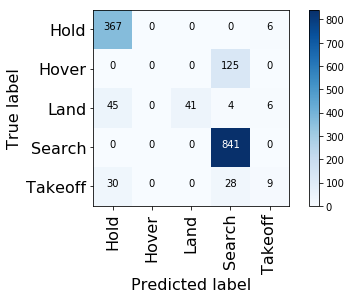

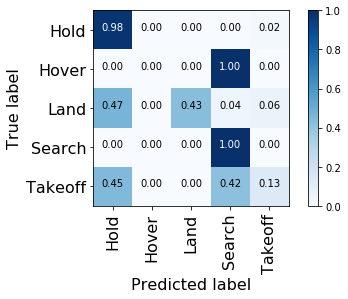

In [16]:
testY_pred = clf.predict(testX)
y_true = testY
y_pred = testY_pred

# # Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
data_class_name = ['Hold', 'Hover', 'Land', 'Search', 'Takeoff']
# # Plot non-normalized confusion matrix
plt.figure()
cm_non_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name,
                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
plt.figure()
cm_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name, normalize=True,
                       title='Normalized confusion matrix')

plt.show()

In [5]:
# Visualize data
dot_data = tree.export_graphviz(clf,
                                feature_names=data_feature_names,
                                class_names=data_class_name,
                                out_file=None,
                                max_depth=None,
                                leaves_parallel=False,
                                filled=True,
                                rounded=True,
                                special_characters=True) 
                         
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

True

scenario accuracy:  0.918
precision:  [0.97 1.   0.   0.89 1.  ]
recall:  [1.   0.55 0.   1.   0.88]
Fscore:  [0.98 0.71 0.   0.94 0.93]
support [236  49  52 599  64]
Confusion matrix, without normalization
[[236   0   0   0   0]
 [  3  27   0  19   0]
 [  0   0   0  52   0]
 [  0   0   0 599   0]
 [  5   0   0   3  56]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.  ]
 [0.06 0.55 0.   0.39 0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.08 0.   0.   0.05 0.88]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


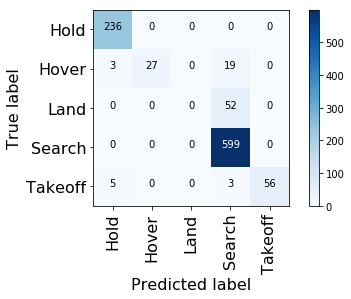

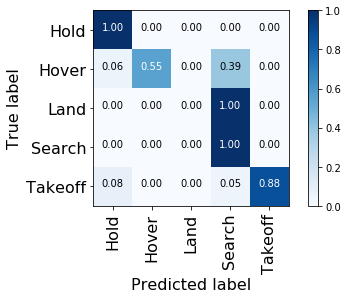

********************************REPORT********************************
The experiment follows the true scenerio  91.8 %.
Details: 
The experiment follows  Hold state     100.0 %,  
			Hover state  55.1 %,  
			Land state    0.0 %,  
			Search state   100.0 %,  
			Takeoff state     87.5 %. 
Recommendation: The following states need to be checked,  ['Hover', 'Land', 'Takeoff']
******************************END REPORT******************************


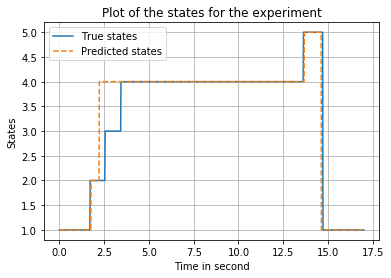

In [17]:
# check a scenerio and generate report
datascenario = pd.read_csv('dataset15.csv')
datascenario = datascenario.dropna()
scenarioX = datascenario.iloc[:,0:4]
scenarioX = scenarioX.reset_index(drop=True)
scenarioX = scenarioX.dropna()
scenarioY = datascenario.iloc[:,-1]
scenarioY = scenarioY.replace(data_class_name_num, data_class_name)
scenarioY = scenarioY.reset_index(drop=True)
scenarioY = scenarioY.dropna()

# scenarioX,scenarioY = simirisX,simirisY
trainX, testX, trainY, testY = train_test_split(scenarioX, scenarioY, 
                                                    test_size=0.1, 
                                                    random_state=np.random.randint(100))
clf = clf.fit(trainX,trainY) 

scenarioY_pred = clf.predict(scenarioX)

scenarioAccuracy = clf.score(scenarioX, scenarioY)
print('scenario accuracy: ', scenarioAccuracy)

y_true = scenarioY
y_pred = scenarioY_pred
        
precision,recall,fbeta_score,support = precision_recall_fscore_support(y_true, 
                                                                       y_pred, 
                                                                       beta=1.0, 
                                                                       labels=None, 
                                                                       pos_label=1, 
                                                                       average=None, 
                                                                       warn_for=('precision', 'recall', 'f-score'), 
                                                                       sample_weight=None)
print('precision: ', precision)
print('recall: ', recall)
print('Fscore: ', fbeta_score)
print('support', support)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

data_class_name = ['Hold', 'Hover', 'Land', 'Search', 'Takeoff']
# Plot non-normalized confusion matrix
plt.figure()
cm_non_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
cm_normalized = plot_confusion_matrix(cnf_matrix, classes=data_class_name, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

y_true = y_true.replace(data_class_name, data_class_name_num)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.replace(data_class_name, data_class_name_num)
time = np.linspace(start=0,stop=17,num=len(y_true))


reco = []
for i in range(len(data_class_name)):
    if cm_normalized[i,i] != 1.0:
        reco.append(data_class_name[i])

print('********************************REPORT********************************')
print('The experiment follows the true scenerio ', scenarioAccuracy*100,'%.')
print('Details: ')
print('The experiment follows  Hold state    ', round(cm_normalized[0,0]*100,2),'%, ',
                            '\n\t\t\tHover state ', round(cm_normalized[1,1]*100,2),'%, ',
                            '\n\t\t\tLand state   ', round(cm_normalized[2,2]*100,2),'%, ',
                            '\n\t\t\tSearch state  ', round(cm_normalized[3,3]*100,2),'%, ',
                            '\n\t\t\tTakeoff state    ', round(cm_normalized[4,4]*100,2),'%. ')
if reco:
    print('Recommendation: The following states need to be checked, ', reco)
plt.figure()
plt.plot(time, y_true,lw=1.5,label='True states')
plt.plot(time, y_pred,'--',lw=1.5,label='Predicted states')
plt.xlabel('Time in second')
plt.ylabel('States')
plt.title('Plot of the states for the experiment')
plt.legend()
plt.grid()
print('******************************END REPORT******************************')
      

# plt.plot(dataX.iloc[1:1000,3])

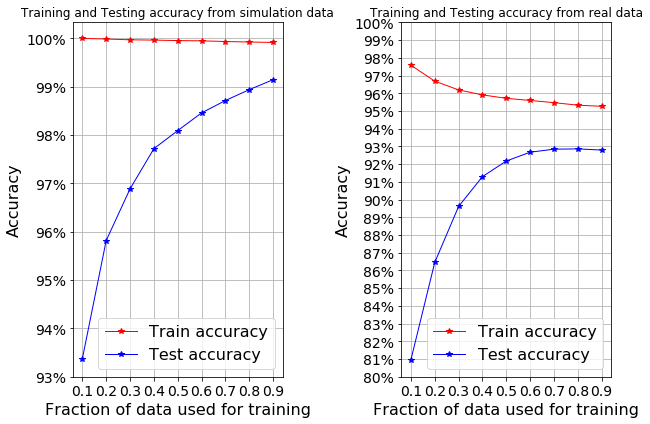

In [21]:

scor0 = []
scor1 = []
for jj in range(2):
    if jj==0:
        X = simonlyconcatX
        Y = simonlyconcatY
    else:
        X = inarX
        Y = inarY
    ######################
    dataX, testdataX, dataY, testdataY = train_test_split(X, Y, 
                                                        test_size=0.2, 
                                                        random_state=np.random.randint(100))
    datap=np.arange(.1,1,.1)
    score0=[]
    score1=[]
    Noofrun=20
    for dp in range(len(datap)):
        score2=0
        score3=0
        for r in range(Noofrun):
            dataPartision = 1.0 - datap[dp]
            trainX, testX, trainY, testY = train_test_split(dataX, dataY, 
                                                        test_size=dataPartision, 
                                                        random_state=np.random.randint(100))
            trainX = trainX.reset_index(drop=True)
            trainX = trainX.dropna()
            trainY = trainY.reset_index(drop=True)
            trainY = trainY.dropna()

            clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
                                          splitter='best', 
                                          max_depth=None,#default None 
                                          min_samples_split=2, 
                                          min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, 
                                          max_features=None, 
                                          random_state=None, 
                                          max_leaf_nodes=None, 
                                          min_impurity_decrease=0.0, 
                                          min_impurity_split=None, 
                                          class_weight=None, 
                                          presort=False)  

    #         clf = svm.LinearSVC()


            clf = clf.fit(trainX, trainY)
            score,precision,recall,fbeta_score,support = calc_stat(clf,trainX,trainY)
            score2 += score
            score,precision,recall,fbeta_score,support = calc_stat(clf,testdataX,testdataY)
            score3 += score
        score2 /= Noofrun
        score0.append(score2*100)
        score3 /= Noofrun
        score1.append(score3*100)
    scor0.append(score0)
    scor1.append(score1)

# import seaborn as sns
# sns.set() 
# fig = plt.gcf()
# fig.set_size_inches(6, 3)
# fig.set_dpi(400)
# plt.plot(datap,score0,label='train accuracy',linewidth=1,c='r')
# plt.plot(datap,score1,label='test accuracy',linewidth=1,c='b')
# plt.legend(prop={'size': 10})
# # plt.grid()
# plt.xlabel('Fraction of data used for training',fontsize=12)
# plt.ylabel('Accuracy',fontsize=12)
# plt.xticks(fontsize=12)
# yticlabel=[str(i) for i in range(90,101)]
# plt.yticks(fontsize=12,label=yticlabel)


#####################

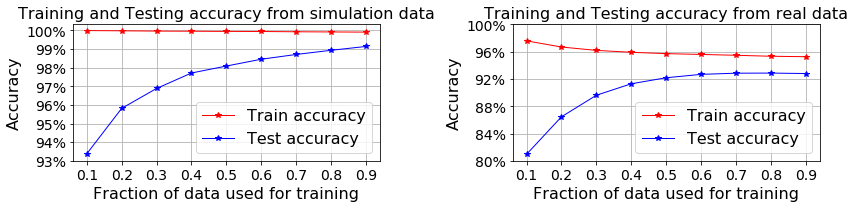

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,3))



ax1.plot(datap, scor0[0], 'r*-',label='train accuracy',linewidth=1)
ax1.plot(datap, scor1[0], 'b*-',label='test accuracy',linewidth=1)
xlabel=[str(round(i,1)) for i in datap]
ytc = np.arange(93,101,1)
ytclbl = [str(i)+'%' for i in ytc]

ax1.set_xticks(datap)
ax1.set_yticks(ytc)
ax1.set_xticklabels(xlabel,fontsize=14)
ax1.set_yticklabels(ytclbl,fontsize=14)
ax1.legend(['Train accuracy', 'Test accuracy'],fontsize=16)
ax1.set_xlabel('Fraction of data used for training',fontsize=16)
ax1.set_ylabel('Accuracy',fontsize=16)
ax1.grid()
ax1.set_title("Training and Testing accuracy from simulation data",fontsize=16)



ax2.plot(datap, scor0[1], 'r*-',label='train accuracy',linewidth=1)
ax2.plot(datap, scor1[1], 'b*-',label='test accuracy',linewidth=1)
xlabel=[str(round(i,1)) for i in datap]
ytc = np.arange(80,101,4)
ytclbl = [str(i)+'%' for i in ytc]

ax2.set_xticks(datap)
ax2.set_yticks(ytc)
ax2.set_xticklabels(xlabel,fontsize=14)
ax2.set_yticklabels(ytclbl,fontsize=14)
ax2.legend(['Train accuracy', 'Test accuracy'],fontsize=16)
ax2.set_xlabel('Fraction of data used for training',fontsize=16)
ax2.set_ylabel('Accuracy',fontsize=16)
ax2.grid()
# ax2.set(title="Training and Testing accuracy from real data")
ax2.set_title("Training and Testing accuracy from real data",fontsize=16)


fig.tight_layout()
         
plt.show()


In [9]:
score0

[100.0,
 100.0,
 99.97276193934992,
 99.96595396976713,
 99.96186948469332,
 99.94098688092969,
 99.92218201626396,
 99.92169413046439,
 99.89105435177339]

In [10]:
score1

[93.28902930602462,
 96.23052620111123,
 97.10208083669245,
 97.79932454515743,
 98.32225732650616,
 98.51835711951193,
 98.76892907724152,
 99.07397319969495,
 99.04128990086066]

In [11]:
1-datap

array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

(array([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]),
 <a list of 10 Text yticklabel objects>)

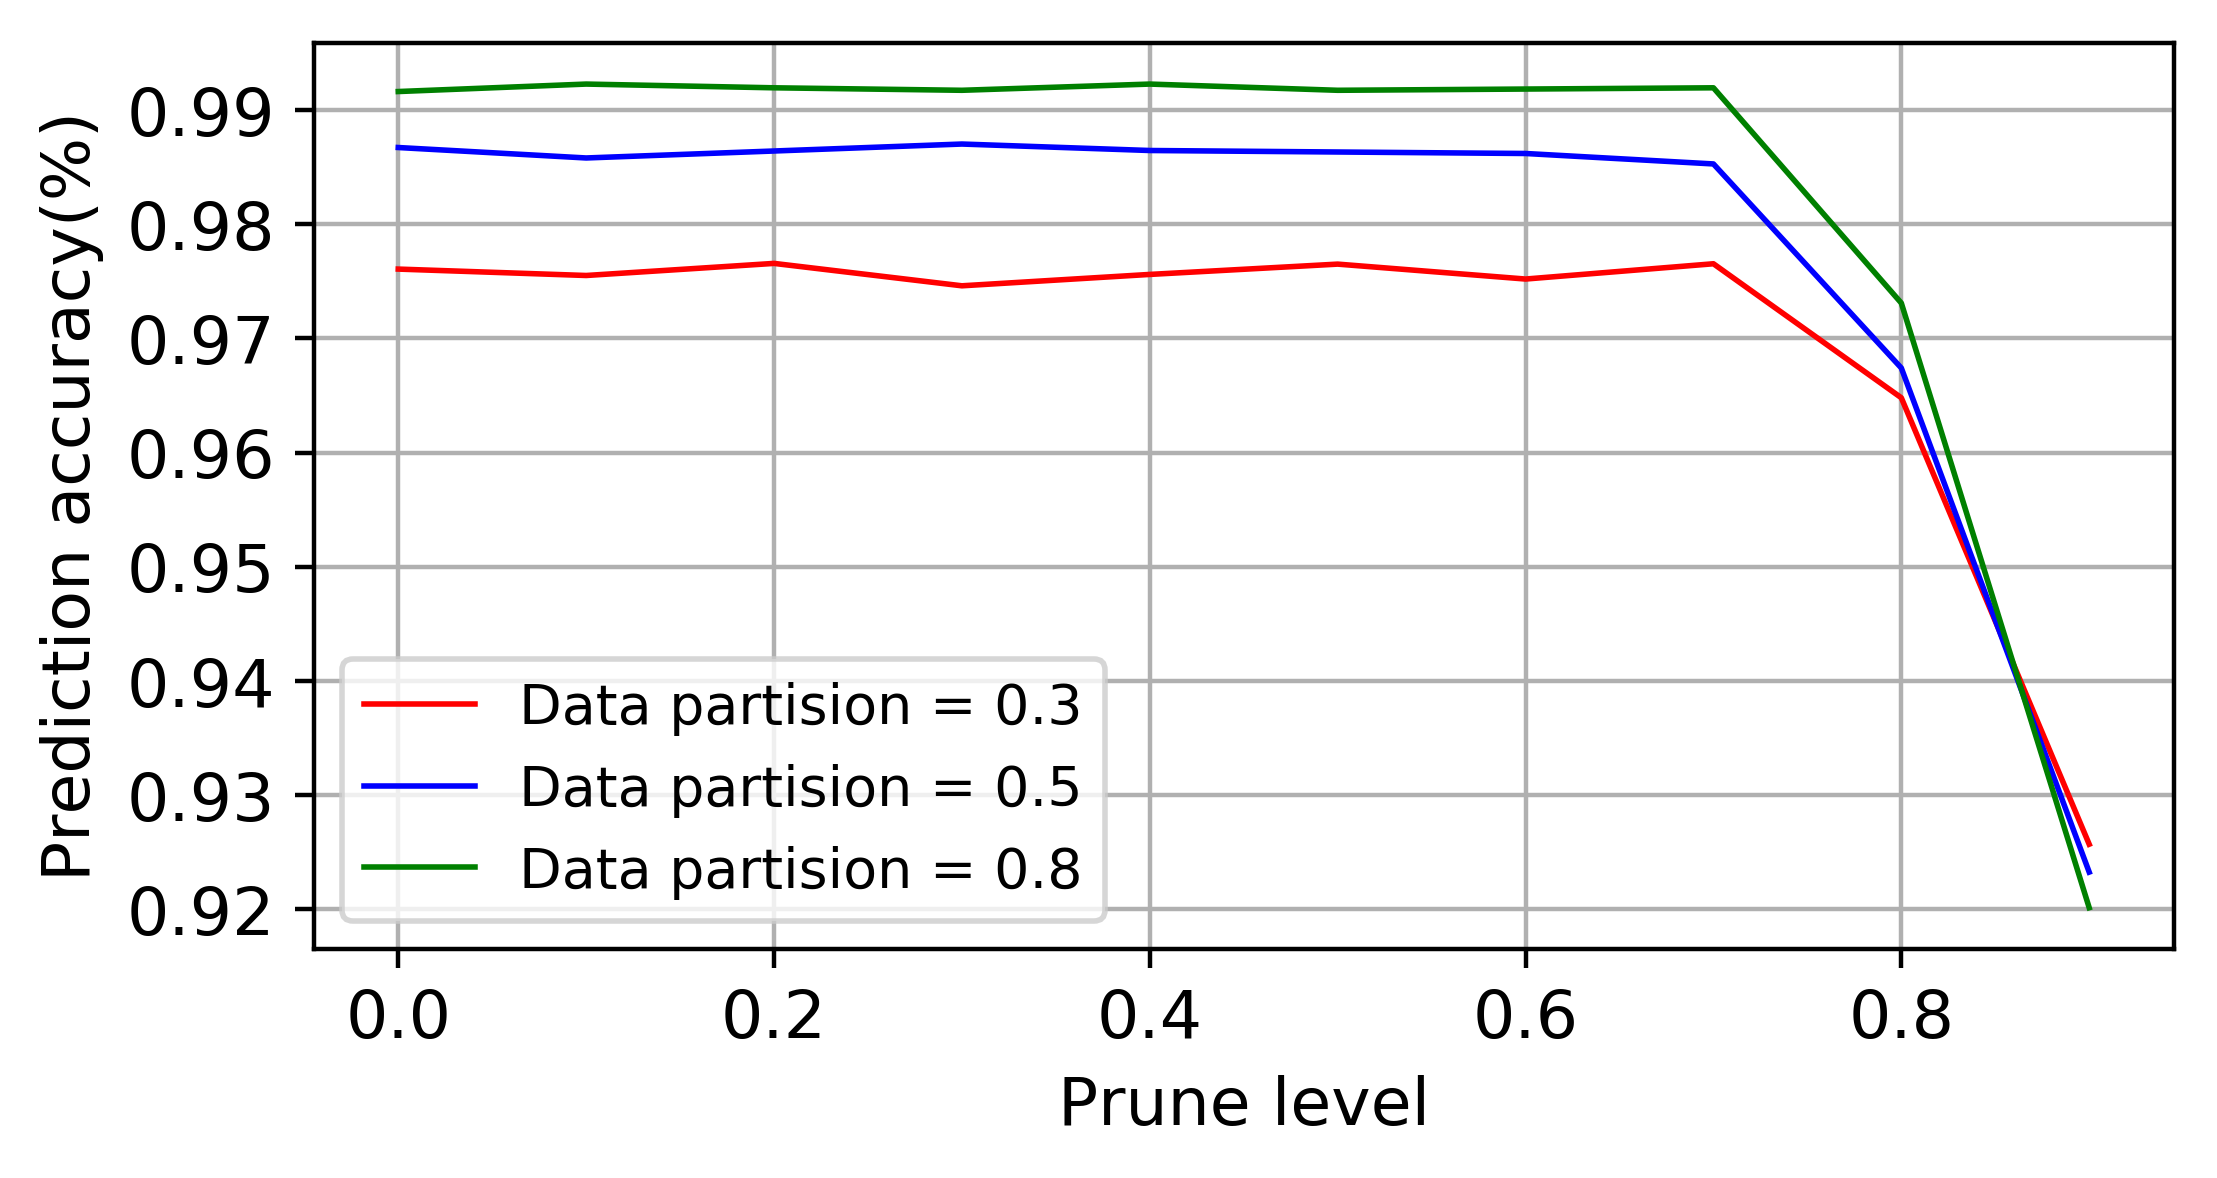

In [12]:
######################
datap=[.7,.5,.2]
prunelevel = np.arange(0.9,-.1,-.1)
score0=[]
score1=[]
for dp in range(len(datap)):
    score2=[]
    dataPartision = datap[dp]
    trainX, testX, trainY, testY = train_test_split(X,Y, 
                                                    test_size=dataPartision, 
                                                    random_state=np.random.randint(100))
    for r in range(len(prunelevel)):
        trainX = trainX.reset_index(drop=True)
        trainX = trainX.dropna()
        trainY = trainY.reset_index(drop=True)
        trainY = trainY.dropna()

        clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
                                      splitter='best', 
                                      max_depth=int(100*(1-prunelevel[r])),#default None 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features=None, 
                                      random_state=None, 
                                      max_leaf_nodes=None, 
                                      min_impurity_decrease=0.0, 
                                      min_impurity_split=None, 
                                      class_weight=None, 
                                      presort=False)                                             


        clf = clf.fit(trainX, trainY)
#         score,precision,recall,fbeta_score,support = calc_stat(clf,testX,testY)
#         score2.append(score*100)
        score,precision,recall,fbeta_score,support = calc_stat(clf,testX,testY)
        score2.append((score))
    score0.append(score2)

# import seaborn as sns
# sns.set() 
fig = plt.gcf()
fig.set_size_inches(6, 3)
fig.set_dpi(400)
plt.plot(prunelevel,score0[0],label='Data partision = 0.3',linewidth=1,c='r')
plt.plot(prunelevel,score0[1],label='Data partision = 0.5',linewidth=1,c='b')
plt.plot(prunelevel,score0[2],label='Data partision = 0.8',linewidth=1,c='g')
plt.legend(prop={'size': 10})
plt.grid()
plt.xlabel('Prune level',fontsize=12)
plt.ylabel('Prediction accuracy(%)',fontsize=12)
# plt.ylabel('Training loss',fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#####################

In [39]:
prunelevel

array([9.00e-01, 8.00e-01, 7.00e-01, 6.00e-01, 5.00e-01, 4.00e-01,
       3.00e-01, 2.00e-01, 1.00e-01, 2.22e-16])

In [23]:
h = np.mean(trainaccClf,axis=1)

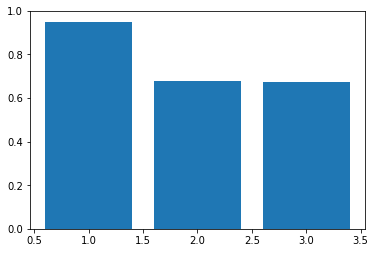

In [24]:
plt.bar([1,2,3],h)
plt.show()